# Experiment Analysis

This notebook is used to analyze the results of certain experiments which can be found in the pycomex experiment archive located at the ``RESULTS_PATH`` directory.

In [5]:
import os
import time
import json
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from rich.pretty import pprint
from pycomex.utils import is_experiment_archive
from pycomex.utils import render_string_table
from pycomex.functional.experiment import Experiment

# This will be the path to the directory in which the notebook is located.
PATH: str = os.getcwd()
# This will have to be the path to the pycomex "results" directory containing the 
# experiment archives of interest.
# HAS TO BE CHANGED, if the analysis is not located in the same directory as the results
# folder.
RESULTS_PATH: str = os.path.join(PATH, 'results')
RESULTS_PATH

'/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results'

In [13]:

# Filter which experiments will be loaded based on their name and/or parameters.
def select_experiment(experiment_name: str,
                      experiment_metadata: dict,
                      experiment_parameters: dict
                      ) -> bool:
    return '__PREFIX__' in experiment_parameters and 'ex_01_p' in experiment_parameters['__PREFIX__']


# Assign a unique key to the experiment based on its data / parameters etc.
# Later on the experiments will be sorted based on this key which will be the 
# key of a dictionary and the values will be a list of all the experiments with 
# that same key.
def sort_experiment(experiment: Experiment) -> tuple:
    
    *_, encoding, dataset = experiment.metadata['name'].split('__')
    method = experiment.parameters['MODELS'][0]
    
    if 'FINGERPRINT_TYPE' in experiment.parameters:
        encoding = experiment.parameters['FINGERPRINT_TYPE']
        
    if 'NOTE' in experiment.parameters:
        dataset = experiment.parameters['NOTE']
    
    return (encoding, dataset, method)

### Experiment Discovery

The following cell will first discover all of the previously executed experiment runs which have been archived in the given results directory. It will then print the number of experiments found.

In [14]:
# This list will contain the paths to the individual expeirment *namespaces* which in 
# turn contain the actual individual experiment archives.
experiment_namespace_paths: list[str] = [
    path
    for file_name in os.listdir(RESULTS_PATH)
    if os.path.isdir(path := os.path.join(RESULTS_PATH, file_name))
]

# Subsequently, this list will contain the paths to the individual experiment archives
# folders.
experiment_paths: list[str] = []
for namespace_path in experiment_namespace_paths:
    for dirpath, dirnames, filenames in os.walk(namespace_path):
        if is_experiment_archive(dirpath):
            experiment_paths.append(dirpath)
            dirnames.clear() # Prevents further recursion into subdirectories
        
print(f'✅ found {len(experiment_paths)} experiment archives in {len(experiment_namespace_paths)} namespaces')
pprint(experiment_paths, max_length=3)

✅ found 23652 experiment archives in 32 namespaces


[
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_29__6zGY',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/debug',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_32__Sozn',
│   ... +23649
]

### Experiment Loading

The following cell will then load the experiment runs into memory selectively based on the previously defined ``select_experiment`` function. Only experiments for which the function returns ``True`` will be loaded into memory. The loaded experiments will actually be restored from the archive by loading the parameters as well as the data back into a ``pycomex.experiment.Experiment`` object.

In [15]:
# This list will be populated with the actual Experiment instances which will 
# be loaded from the experiment archive folders.
experiments: list[Experiment] = []

print('Loading experiments from archives...')
time_start: float = time.time()
for experiment_path in experiment_paths:
    
    experiment_identifier: str = os.path.basename(experiment_path)
    
    experiment_data_path = os.path.join(experiment_path, Experiment.DATA_FILE_NAME)
    if not os.path.exists(experiment_data_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no data found')
        continue
    
    experiment_meta_path = os.path.join(experiment_path, Experiment.METADATA_FILE_NAME)
    if not os.path.exists(experiment_meta_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no metadata found')
        continue
    
    with open(experiment_meta_path) as file:
        content = file.read()
        # This will contain the experiment metadata as a dictionary which we can now use to
        # filter for instance.
        experiment_metadata: dict = json.loads(content)
        
    if 'parameters' not in experiment_metadata:
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no parameters found')
        continue
    
    experiment_parameters: dict = {
        param: info['value']
        for param, info in experiment_metadata['parameters'].items()
        if 'value' in info
    }
    
    # Here we apply the filter to determine whether or not the experiment should be included
    # in the analysis.
    condition: bool = select_experiment(
        experiment_name=experiment_metadata['name'],
        experiment_metadata=experiment_metadata,
        experiment_parameters=experiment_parameters
    )
    
    if condition:
        try:
            print(f'   > included experiment "{experiment_identifier}"')
            experiment: Experiment = Experiment.load(experiment_path)
            experiments.append(experiment)
        except Exception as e:
            print(f'   ⚠️ Failed to load experiment "{experiment_identifier}" - Exception: {e}')
            
time_end: float = time.time()
duration: float = time_end - time_start
print(f'✅ Loaded {len(experiments)} experiments in {duration:.2f} seconds')

Loading experiments from archives...
   ⚠️ Skipping experiment "debug" - no data found
   > included experiment "ex_01_p__18_08_2025__14_50__OBvb"
   > included experiment "ex_01_p__19_08_2025__03_20__BODH"
   ⚠️ Skipping experiment "ex_00_c__17_08_2025__16_08__JXbr" - no data found
   > included experiment "ex_01_p__19_08_2025__00_31__SO6Y"
   > included experiment "ex_01_p__19_08_2025__03_13__XQHQ"
   > included experiment "ex_01_p__18_08_2025__15_18__CMSZ"
   > included experiment "ex_01_p__18_08_2025__15_23__a0Ew"
   > included experiment "ex_01_p__18_08_2025__22_45__8vHQ"
   > included experiment "ex_01_p__19_08_2025__05_05__bt7I"
   > included experiment "ex_01_p__19_08_2025__04_35__jVK6"
   > included experiment "ex_01_p__18_08_2025__14_58__8ZfR"
   > included experiment "ex_01_p__19_08_2025__07_21__As0b"
   > included experiment "ex_01_p__19_08_2025__00_28__DBgV"
   > included experiment "ex_01_p__19_08_2025__03_13__XQHQ"
   > included experiment "ex_01_p__18_08_2025__15_18__CM

In [16]:
example_experiment: Experiment = experiments[0] if experiments else None
print(f'{len(experiments)} experiments loaded')
pprint(example_experiment.data, max_length=10)

322 experiments loaded


{
│   'indices': {
│   │   'train': [845, 302, 8854, 1114, 8386, 8520, 9491, 9388, 7542, 6756, ... +8879],
│   │   'val': [3014, 4497, 2475, 7498, 9260, 6135, 2437, 5075, 292, 3075],
│   │   'test': [3898, 9711, 8918, 2136, 6061, 7768, 9518, 1073, 215, 7689, ... +978]
│   },
│   'metrics': {
│   │   'test_k_neighbors': {'r2': 0.8791645928736511, 'mse': 3.6478950668010683, 'mae': 1.2160973929520205}
│   }
}

### Experiment Sorting

The following cell will sort the - currently still unsorted - experiment list by a custom criteria defined in the ``sort_experiments`` function. This is done by putting all the experiments into the same list for which this function returns the same index tuple. The result is the ``key_experiment_map`` dictionary data structure which maps the index tuple to a list of experiments.

In [17]:
# This will be a dictionary mapping the unique key of the experiment to a list of
# experiments which share that key. This will allow us to group experiments based on
# their parameters or other attributes.
key_experiment_map: dict[tuple, list[Experiment]] = defaultdict(list)

for experiment in experiments:
    key: tuple = sort_experiment(experiment)
    key_experiment_map[key].append(experiment)
    
key_experiment_map = dict(sorted(key_experiment_map.items(), key=lambda item: item[0][0] + item[0][1] + item[0][2])) 
pprint(key_experiment_map, max_length=5)

{
│   ('gnn', 'aqsoldb', 'gatv2'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe55524d0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe5558210>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe5399c10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe53a1a50>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe5291890>
│   ],
│   ('gnn', 'clogp', 'gatv2'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe56620d0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe5662b10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe5561810>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe55d14d0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfe5550950>
│   ],
│   ('gnn', 'qm9_energy', 'gatv2'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd6ab5410>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd66852d0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd66c6e10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd684f250>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd68d5ed0>
│   ],
│   ('gnn', 'qm9_gap', 'gatv2'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd69098d0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd6a4fe10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd6eb8410>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd68d7ad0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd677b250>
│   ],
│   ('hdc', 'aqsoldb', 'grad_boost'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd748ca50>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd71addd0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd7033d10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd6dbe2d0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7fdfd6bad0d0>
│   ],
│   ... +59
}

### Experiment Result Table

The following cell illustrates how to create a table from the aggregated results of many loaded experiments, which is a common use case of the analysis.

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Encoding', 'Dataset', 'Method', 'Result']

# This data structure will hold the (encoding, dataset, method) tuple as keys and the metric
# values as a list value.
key_values_map = defaultdict(list)

for (encoding, dataset, method), _experiments in key_experiment_map.items():
    
    example_experiment = _experiments[0]
    if example_experiment.parameters['DATASET_TYPE'] == 'regression':
        metric = 'r2'
    else:
        metric = 'f1'
        
    values = [exp.data['metrics'][f'test_{method}'][metric] for exp in _experiments if 'metrics' in exp.data]
    mean_value = np.mean(values)
    std_value = np.std(values)
    
    table.add_row([
        encoding,
        dataset,
        method,
        f'{mean_value:.2f} ± {std_value:.2f}',
    ])
    
    key_values_map[(encoding, dataset, method)] = values
    
print(table.get_string())

+----------+------------+---------------+--------------+
| Encoding |  Dataset   |     Method    |    Result    |
+----------+------------+---------------+--------------+
|   gnn    |  aqsoldb   |     gatv2     | 0.85 ± 0.01  |
|   gnn    |   clogp    |     gatv2     | 0.99 ± 0.00  |
|   gnn    | qm9_energy |     gatv2     | 1.00 ± 0.00  |
|   gnn    |  qm9_gap   |     gatv2     | 0.93 ± 0.01  |
|   hdc    |  aqsoldb   |   grad_boost  | 0.52 ± 0.01  |
|   hdc    |  aqsoldb   |  k_neighbors  | 0.76 ± 0.01  |
|   hdc    |  aqsoldb   |   neural_net  | 0.82 ± 0.01  |
|   hdc    |  aqsoldb   |  neural_net2  | 0.83 ± 0.01  |
|   hdc    |  aqsoldb   | random_forest | 0.77 ± 0.01  |
|   hdc    |   clogp    |   grad_boost  | 0.59 ± 0.01  |
|   hdc    |   clogp    |  k_neighbors  | 0.89 ± 0.01  |
|   hdc    |   clogp    |   neural_net  | 0.98 ± 0.00  |
|   hdc    |   clogp    |  neural_net2  | 0.98 ± 0.00  |
|   hdc    |   clogp    | random_forest | 0.90 ± 0.01  |
|   hdc    | qm9_energy |   gra

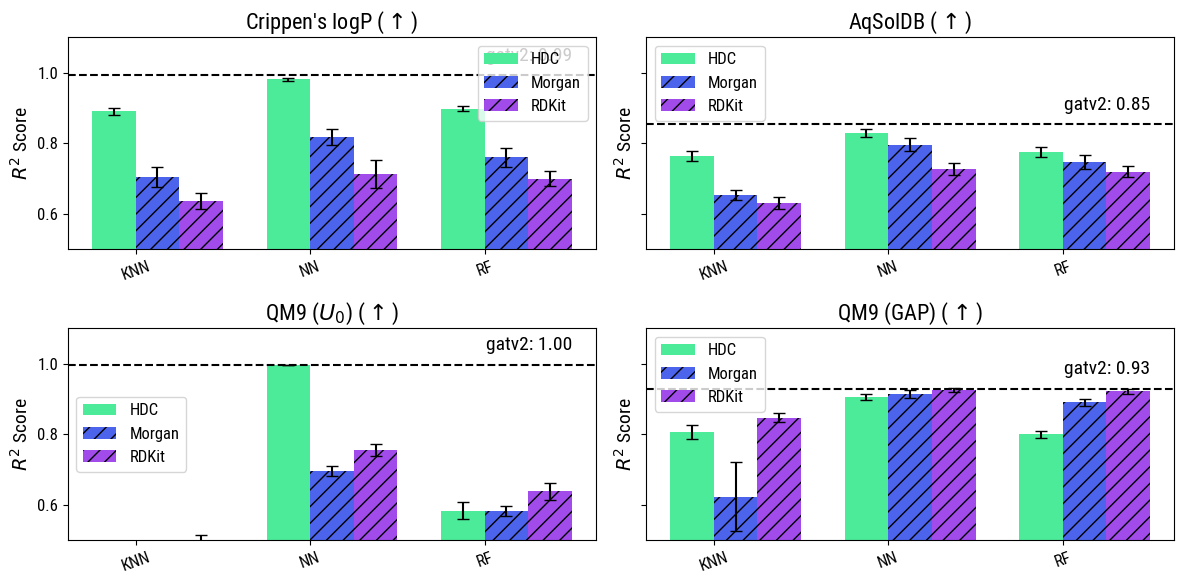

In [34]:
plt.style.use('default')
plt.rcParams['font.family'] = 'Roboto Condensed'

datasets = [
    'clogp', 
    'aqsoldb',
    'qm9_energy',
    'qm9_gap', 
    #'qm9_smiles', 
    #'conjugated', 
    #'bbbp', 
    #'ames'
]
methods = [
    #'grad_boost', 
    'k_neighbors', 
    #'linear', 
    #'neural_net', 
    'neural_net2',
    'random_forest',
]
encodings = [
    'hdc', 
    #'fp'
    'morgan',
    'rdkit',
]
colors = {'hdc': "#4CEB99", 'fp': "#4C64EB", 'morgan': '#4C64EB', 'rdkit': '#A14BEB'}

# This map determines whether the bars should be drawn with a hatch pattern or not.
hatched = {'hdc': False, 'fp': True, 'morgan': True, 'rdkit': True}

encoding_label_map = {
    'hdc': 'HDC',
    'fp': 'FP',
    'gnn': 'GNN',
    'morgan': 'Morgan',
    'rdkit': 'RDKit',
}

dataset_label_map = {
    'clogp': r"Crippen's logP ($\uparrow$)",
    'aqsoldb': r'AqSolDB ($\uparrow$)',
    'qm9_smiles': r'QM9 (GAP) ($\uparrow$)',
    'conjugated': r'Conjugated ($\uparrow$)',
    'bbbp': r'BBBP ($\uparrow$)',
    'ames': r'Mutagenicity ($\uparrow$)',
    'qm9_gap': r'QM9 (GAP) ($\uparrow$)',
    'qm9_energy': r'QM9 ($U_0$) ($\uparrow$)',
}

method_label_map = {
    'grad_boost': 'GB',
    'k_neighbors': 'KNN',
    #'linear': 'LR',
    #'neural_net': 'NN',
    'neural_net2': 'NN',
    'random_forest': 'RF',
}

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharey=True)
axes = axes.flatten()
plt.rcParams.update({'font.size': 12})

for i, dataset in enumerate(datasets):
    ax = axes[i]
    bar_positions = np.arange(len(methods))
    width = 0.25

    for j, encoding in enumerate(encodings):
        means = []
        stds = []
        for method in methods:
            vals = key_values_map.get((encoding, dataset, method), [])
            means.append(np.mean(vals) if vals else np.nan)
            stds.append(np.std(vals) if vals else np.nan)
        
        hatch_pattern = '//' if hatched.get(encoding, False) else None
        ax.bar(
            bar_positions + (j-0.5)*width,
            means,
            width=width,
            yerr=stds,
            label=encoding_label_map.get(encoding, encoding),
            color=colors[encoding],
            capsize=4,
            hatch=hatch_pattern,
        )

    # GATv2 GNN baseline
    gnn_vals = key_values_map.get(('gnn', dataset, 'gatv2'), [])
    if gnn_vals:
        gnn_mean = np.mean(gnn_vals)
        ax.axhline(gnn_mean, color='black', linestyle='--')
        ax.text(
            len(methods)-0.5,
            gnn_mean + 0.03,
            f'gatv2: {gnn_mean:.2f}',
            va='bottom',
            ha='right',
            color='black',
            fontsize=14
        )

    ax.set_xticks(bar_positions)
    ax.set_xticklabels([method_label_map.get(m, m) for m in methods], rotation=20)
    ax.set_title(dataset_label_map.get(dataset, dataset))
    ax.set_ylabel('$R^2$ Score')
    ax.legend()

ax.set_ylim(0.5, 1.1)  # Adjust y-axis limit for better visibility
for ax in axes:
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.title.set_size(16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()